In [1]:
import torch
from torchvision.models import vgg16
from torchvision import models, transforms
from torch.optim import SGD
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from PIL import Image
import copy

In [2]:
def prep_img(orig_img):
  orig_RGB_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
  rsz_img = cv2.resize(orig_RGB_img,(224,224))
  img_arr = (np.float32(rsz_img)).transpose(2,0,1)

  mean = [0.485, 0.456, 0.406]
  stdev = [0.229, 0.224, 0.225]

  for C in range(3):
    img_arr[C] = (img_arr[C]/255-mean[C])/stdev[C]

  img_arr = (torch.from_numpy(img_arr).float()).unsqueeze_(0)
  img_var = Variable(img_arr, requires_grad=True)

  return img_var

In [3]:
def prep_inv_img(img_var):
  mean = [0.485, 0.456, 0.406]
  stdev = [0.229, 0.224, 0.225]
  
  rec_img = copy.copy(img_var.data.numpy()[0])

  for C in range(3):
    rec_img[C] = (rec_img[C]*stdev[C])+mean[C]

  rec_img = np.clip(rec_img,0,1)
  rec_img = np.round(rec_img * 255)

  rec_img = np.uint8(rec_img).transpose(1, 2, 0)
  return rec_img


In [8]:
class inverted_rep():
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def get_layer_out(self, inp, layer_num):
        out = None
        for idx, layer in enumerate(self.model.features):
            inp = layer(inp)
            if str(idx) == str(layer_num):
                out = inp[0]
                break
        return out

    def get_inv_img(self, img, layer_num):
        reg1_alpha = 6
        reg1_lambda = 1e-7
        reg2_beta = 2
        reg2_lambda = 1e-8
        euc_const = 1e-1
        iter =200
        lr = 1e4
        momentum = 0.9

        out_img = Variable(1e-1*torch.randn(1, 3, 224, 224), requires_grad=True)
        optimizer = SGD([out_img], lr=lr, momentum=momentum)

        orig_feat = self.get_layer_out(img, layer_num)

        for i in range(iter):
            optimizer.zero_grad()

            out_feat = self.get_layer_out(out_img, layer_num)

            loss = euc_const* self.euc_loss(orig_feat.detach(), out_feat) + reg1_lambda * self.Reg_1(out_img, reg1_alpha) + reg2_lambda * self.Reg_2(out_img,reg2_beta)
            loss.backward()
            optimizer.step()

            if i % 5 == 0:
                print('No. of Iters:', str(i), 'Total Loss:', loss.data.numpy())
                recreated_im = prep_inv_img(out_img)
                plt.imshow(recreated_im)

            if i % 40 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1/10

  
    def Reg_1(self, inp, alpha):
        norm_1 = ((inp.view(-1))**alpha).sum()
        return norm_1

    def Reg_2(self, inp, beta):
        xij = inp[:, :-1, :-1] 
        xij1 = inp[:, 1:, :-1] 
        x1ij = inp[:, :-1, 1:] 
        norm_2 = (((xij - xij1)**2 + (xij - x1ij)**2)**(beta/2)).sum()
        return norm_2

    def euc_loss(self, my_feat, orig_feat):
        dist= orig_feat - my_feat
        euc_dist = self.Reg_1(dist, 2)
        norm_loss = euc_dist / self.Reg_1(my_feat, 2)
        return norm_loss

No. of Iters: 0 Total Loss: 0.09924149
No. of Iters: 5 Total Loss: 0.05481091
No. of Iters: 10 Total Loss: 0.043258287
No. of Iters: 15 Total Loss: 0.03586151
No. of Iters: 20 Total Loss: 0.031341486
No. of Iters: 25 Total Loss: 0.028025357
No. of Iters: 30 Total Loss: 0.0255318
No. of Iters: 35 Total Loss: 0.023623478
No. of Iters: 40 Total Loss: 0.022131404
No. of Iters: 45 Total Loss: 0.021765873
No. of Iters: 50 Total Loss: 0.021625353
No. of Iters: 55 Total Loss: 0.02148972
No. of Iters: 60 Total Loss: 0.021362238
No. of Iters: 65 Total Loss: 0.021242585
No. of Iters: 70 Total Loss: 0.021129407
No. of Iters: 75 Total Loss: 0.02102165
No. of Iters: 80 Total Loss: 0.020918446
No. of Iters: 85 Total Loss: 0.020890206
No. of Iters: 90 Total Loss: 0.020880148
No. of Iters: 95 Total Loss: 0.020870192
No. of Iters: 100 Total Loss: 0.02086033
No. of Iters: 105 Total Loss: 0.02085053
No. of Iters: 110 Total Loss: 0.020840788
No. of Iters: 115 Total Loss: 0.020831103
No. of Iters: 120 Total

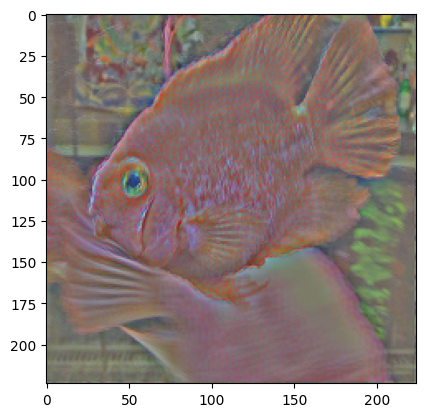

In [9]:
img = prep_img(cv2.imread("goldfish.jpeg"))
model = vgg16(pretrained=True)
inverted_img = inverted_rep(model)
inverted_img.get_inv_img(img,5)